# Heart disease prediction using SVM

## Importing the modules

In [1]:
import pandas as pd # pandas is used to load and manipulate data and for One-Hot Encoding
import numpy as np # numpy is used to calculate the mean and standard deviation
import matplotlib.pyplot as plt # matplotlib is for drawing graphs
import matplotlib.colors as colors
from sklearn.model_selection import train_test_split # split  data into training and testing sets
from sklearn.preprocessing import scale # scale and center data
from sklearn.svm import SVC # this will make a support vector machine for classificaiton
from sklearn.model_selection import GridSearchCV # this will do cross validation
from sklearn.metrics import confusion_matrix # this creates a confusion matrix
from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix
from sklearn.decomposition import PCA # to perform PCA to plot the data

## Importing the data
Now we load in a dataset from the **[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php)**.
Specifically, we are going to use the **[Heart Disease Dataset](https://archive.ics.uci.edu/ml/datasets/Heart+Disease)**. 

This dataset will allow us to predict if someone has heart disease based on their sex, age, blood pressure and a variety of other metrics.

In [2]:
df = pd.read_csv('processed.cleveland.data', 
                 header=None)

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


We see that instead of nice column names, we just have column numbers.  Since nice column names would make it easier to know how to format the data, let's replace the column numbers with the following column names:
- **age**,
- **sex**,
- **cp**, chest pain
- **restbp**, resting blood pressure (in mm Hg)
- **chol**, serum cholesterol in mg/dl
- **fbs**, fasting blood sugar
- **restecg**, resting electrocardiographic results
- **thalach**,  maximum heart rate achieved
- **exang**, exercise induced angina
- **oldpeak**, ST depression induced by exercise relative to rest
- **slope**, the slope of the peak exercise ST segment.
- **ca**, number of major vessels (0-3) colored by fluoroscopy
- **thal**, this is short of thalium heart scan.
- **hd**, diagnosis of heart disease, the predicted attribute

In [4]:
df.columns = ['age',
              'sex',
              'cp',
              'restbp',
              'chol',
              'fbs',
              'restecg',
              'thalach',
              'exang',
              'oldpeak',
              'slope',
              'ca',
              'thal',
              'hd']
df.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


## Identifying Missing Data

In [5]:
df.dtypes

age        float64
sex        float64
cp         float64
restbp     float64
chol       float64
fbs        float64
restecg    float64
thalach    float64
exang      float64
oldpeak    float64
slope      float64
ca          object
thal        object
hd           int64
dtype: object

We see that that they are almost all `float64`, however, two columns, **ca** and **thal**, have the `object` type and one column, **hd** has `int64`.

In [6]:
df['ca'].unique()

array(['0.0', '3.0', '2.0', '1.0', '?'], dtype=object)

We see that **ca** contains numbers (0.0, 3.0, 2.0 and 1.0) and questions marks (?). The numbers represent the number of blood vessels that we lit up by fluoroscopy and the question marks represent missing data.

Now let's look at the unique values in **thal**.

In [7]:
df['thal'].unique()

array(['6.0', '3.0', '7.0', '?'], dtype=object)

Again, **thal** also contains a mixture of numbers, representing the different diagnoses from the thalium heart scan, and question marks, which represent missing values.

## Dealing With Missing Data

In [8]:
len(df.loc[(df['ca'] == '?') | (df['thal'] == '?')])

6

In [9]:
df.loc[(df['ca'] == '?') | (df['thal'] == '?')]

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,?,0
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,?,2
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0


In [10]:
len(df)

303

In [11]:
df_no_missing = df.loc[(df['ca'] != '?') & (df['thal'] != '?')]

In [12]:
len(df_no_missing)

297

## Splitting the data

In [13]:
X = df_no_missing.drop('hd', axis=1).copy() # alternatively: X = df_no_missing.iloc[:,:-1].copy()
X.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0


In [14]:
y = df_no_missing['hd'].copy()
y.head()

0    0
1    2
2    1
3    0
4    0
Name: hd, dtype: int64

## Formatting the Data: One-Hot Encoding

- **age**, **Float**
- **sex** - **Category**
  - 0 = female
  - 1 = male
- **cp**, chest pain, **Category**
  - 1 = typical angina,
  - 2 = atypical angina,
  - 3 = non-anginal pain,
  - 4 = asymptomatic
- **restbp**, resting blood pressure (in mm Hg), **Float**
- **chol**, serum cholesterol in mg/dl, **Float**
- **fbs**, fasting blood sugar, **Category**
  - 0 = >=120 mg/dl
  - 1 = <120 mg/dl
- **restecg**, resting electrocardiographic results, **Category**
  - 1 = normal
  - 2 = having ST-T wave abnormality
  - 3 = showing probable or definite left ventricular hypertrophy
- **thalach**,  maximum heart rate achieved, **Float**
- **exang**, exercise induced angina, **Category**
  - 0 = no
  - 1 = yes
- **oldpeak**, ST depression induced by exercise relative to rest. **Float**
- **slope**, the slope of the peak exercise ST segment, **Category**
  - 1 = upsloping
  - 2 = flat
  - 3 = downsloping
- **ca**, number of major vessels (0-3) colored by fluoroscopy, **Float**
- **thal**, thalium heart scan, **Category**
  - 3 = normal (no cold spots)
  - 6 = fixed defect (cold spots during rest and exercise)
  - 7 = reversible defect (when cold spots only appear during exercise)

In [15]:
X['cp'].unique()

array([1., 4., 3., 2.])

In [16]:
pd.get_dummies(X, columns=['cp']).head()

,age,sex,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,cp_1.0,cp_2.0,cp_3.0,cp_4.0
0,63.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,1,0,0,0
1,67.0,1.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,0,0,0,1
2,67.0,1.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,0,0,0,1
3,37.0,1.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,1,0
4,41.0,0.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,1,0,0


In [17]:
X_encoded = pd.get_dummies(X, columns=['cp',
                                       'restecg',
                                       'slope', 
                                       'thal'])
X_encoded.head()

,age,sex,restbp,chol,fbs,thalach,exang,oldpeak,ca,cp_1.0,...,cp_4.0,restecg_0.0,restecg_1.0,restecg_2.0,slope_1.0,slope_2.0,slope_3.0,thal_3.0,thal_6.0,thal_7.0
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0.0,1,...,0,0,0,1,0,0,1,0,1,0
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,3.0,0,...,1,0,0,1,0,1,0,1,0,0
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,2.0,0,...,1,0,0,1,0,1,0,0,0,1
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0.0,0,...,0,1,0,0,0,0,1,1,0,0
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0.0,0,...,0,0,0,1,1,0,0,1,0,0


In [18]:
y.unique()

array([0, 2, 1, 3, 4], dtype=int64)

Since we're only making a support vector machine that does simple classification and only care if someone has heart disease or not, we need to convert all numbers **> 0** to **1**.

In [19]:
y_not_zero_idx = y > 0
y[y_not_zero_idx] = 1
y.unique()

array([0, 1], dtype=int64)

## Format the Data: Centering and Scaling

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

## Building A Preliminary Support Vector Machine

In [21]:
clf_svm = SVC(random_state=42)
clf_svm.fit(X_train_scaled, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

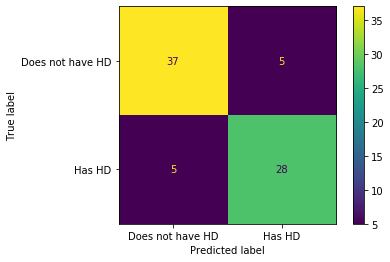

In [22]:
plot_confusion_matrix(clf_svm, 
                      X_test_scaled, 
                      y_test, 
                      display_labels=["Does not have HD", "Has HD"])

## Optimizing Parameters with Cross Validation

In [23]:
param_grid = [
  {'C': [1, 10, 100, 1000], 
   'gamma': [0.001, 0.0001], 
   'kernel': ['rbf']},
 ]

optimal_params = GridSearchCV(
        SVC(), 
        param_grid,
        cv=5,
        verbose=0 # NOTE: If you want to see what Grid Search is doing, set verbose=2
    )

optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}


## Building, Evaluating, Drawing, and Interpreting the Final Support Vector Machine

In [24]:
clf_svm = SVC(random_state=42, C=1, gamma=0.01)
clf_svm.fit(X_train_scaled, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

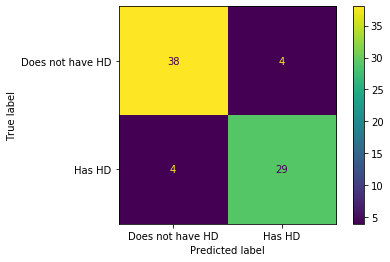

In [25]:
plot_confusion_matrix(clf_svm, 
                      X_test_scaled, 
                      y_test, 
                      display_labels=["Does not have HD", "Has HD"])

In [26]:
len(df.columns)

14

So we see that there are **14** features, or columns, in **X**. 
This is a problem because it would require a 14-dimensional graph, one dimension per feature used to make predictions, to plot the data in its raw form. If we wanted to, we could just pick two features at random to use as x and y-axes on our graph, but instead , we will use **PCA** (Principal Component Analysis) to combine the **14** features into **2** orthogonal meta-features that we can use as axes for a graph.

However, before we shrink the graph, let's first determine how accurate the shrunken graph will be. If it's relatively accurate, than it makes sense to draw the 2-Dimensional graph. If not, the shrunken graph will not be very useful. We can determine the accuracy of the graph by drawing something called a **scree plot**.

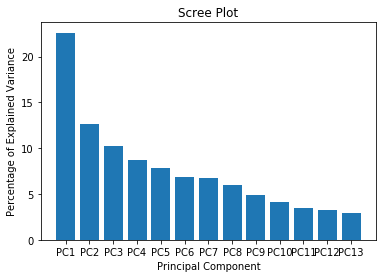

In [27]:
pca = PCA() # By default, PCA() centers the data, but does not scale it.
X_train_pca = pca.fit_transform(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
 
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

The scree plot shows that the first principal component, PC1, accounts for a relatively large amount of variation in the raw data, and this means that it will be a good candidate for the x-axis in the 2-dimensional graph. Since PC2 accounts for the next largest amount of variance, we will use that for the y-axis.

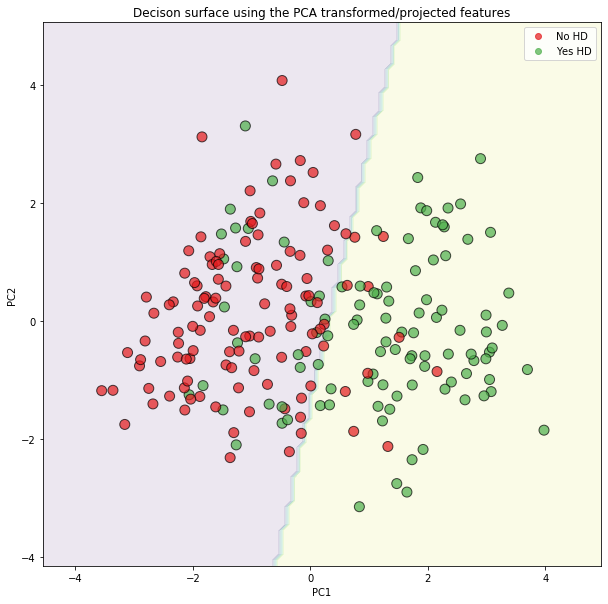

In [28]:
pc1 = X_train_pca[:, 0] 
pc2 = X_train_pca[:, 1]

## NOTE:
## pc1 contains the x-axis coordinates of the data after PCA
## pc2 contains the y-axis coordinates of the data after PCA

## Now we fittthe SVM to the x and y-axis coordinates
## of the data after PCA dimension reduction...
clf_svm.fit(np.column_stack((pc1, pc2)), y_train)

## Now create a matrix of points that we can use to show
## the decision regions.
## The matrix will be a little bit larger than the
## transformed PCA points so that we can plot all of
## the PCA points on it without them being on the edge
x_min = pc1.min() - 1
x_max = pc1.max() + 1

y_min = pc2.min() - 1
y_max = pc2.max() + 1

xx, yy = np.meshgrid(np.arange(start=x_min, stop=x_max, step=0.1),
                     np.arange(start=y_min, stop=y_max, step=0.1))

## now we will classify every point in that 
## matrix with the SVM. Points on one side of the 
## classification boundary will get 0, and points on the other
## side will get 1.
Z = clf_svm.predict(np.column_stack((xx.ravel(), yy.ravel())))
## Right now, Z is just a long array of lots of 0s and 1s, which
## reflect how each point in the mesh was classified.
## We use reshape() so that each classification (0 or 1) corresponds
## to a specific point in the matrix.
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(10,10))
## now we will use contourf() to draw a filled contour plot
## using the matrix values and classifications. 
## The contours will be filled according to the 
## predicted classifications (0s and 1s) in Z
ax.contourf(xx, yy, Z, alpha=0.1)

## now create custom colors for the actual data points
cmap = colors.ListedColormap(['#e41a1c', '#4daf4a'])
## now darw the actual data points - these will
## be colored by their known (not predcited) classifications
## NOTE: setting alpha=0.7 lets us see if we are covering up a point 
scatter = ax.scatter(pc1, pc2, c=y_train, 
               cmap=cmap, 
               s=100, 
               edgecolors='k', ## 'k' = black
               alpha=0.7)

## now create a legend
legend = ax.legend(scatter.legend_elements()[0], 
                   scatter.legend_elements()[1],
                    loc="upper right")
legend.get_texts()[0].set_text("No HD")
legend.get_texts()[1].set_text("Yes HD")

## now add axis labels and titles
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_title('Decison surface using the PCA transformed/projected features')
# plt.savefig('svm.png')
plt.show()

# Thanks